In [6]:
import os
import cv2
import numpy as np
import json
from detectron2.data import detection_utils as utils
from IPython.display import display
from PIL import Image
import json
from collections import defaultdict
annotation_file = '/data3/chengyeh/TAO/amodal_annotations/test_with_freeform_amodal_boxes_Jan10_2023.json'
mask_annotation = "/data3/chengyeh/TAO/BURST_annotations/test/all_classes.json"
with open(annotation_file, 'r') as f:
    tao_amodal = json.load(f)

img_id_to_img = {image['id']: image for image in tao_amodal['images']}
vname_to_img_ids = defaultdict(list)
vid_to_vname = dict()
vid_to_tracks = defaultdict(list)
img_name_to_id = defaultdict(int)
img_id_to_vname = dict()
for video in tao_amodal['videos']:
    vid_to_vname[video['id']] = video['name']

for img in tao_amodal['images']:
    vname_to_img_ids[img['video']].append(img['id'])
    img_name_to_id[img['file_name']] = img['id']
    img_id_to_vname[img['id']] = vid_to_vname[img['video_id']]



In [7]:

img_id_to_prediction = defaultdict(list)
img_id_to_modal_prediction = defaultdict(list)
img_id_to_ann = defaultdict(list)

 
for ann in tao_amodal['annotations']:
    img_id_to_ann[ann['image_id']].append(ann)
    vid_to_tracks[ann['video_id']].append(ann['track_id'])

for vid in vid_to_tracks:
    vid_to_tracks[vid] = list(sorted(vid_to_tracks[vid]))

In [8]:
import numpy as np
import collections
import itertools

def colormap(rgb=False, as_int=False):
    color_list = np.array(
        [
            0.000, 0.447, 0.741,
            0.850, 0.325, 0.098,
            0.929, 0.694, 0.125,
            0.494, 0.184, 0.556,
            0.466, 0.674, 0.188,
            0.301, 0.745, 0.933,
            0.635, 0.078, 0.184,
            0.300, 0.300, 0.300,
            0.600, 0.600, 0.600,
            1.000, 0.000, 0.000,
            1.000, 0.500, 0.000,
            0.749, 0.749, 0.000,
            0.000, 1.000, 0.000,
            0.000, 0.000, 1.000,
            0.667, 0.000, 1.000,
            0.333, 0.333, 0.000,
            0.333, 0.667, 0.000,
            0.333, 1.000, 0.000,
            0.667, 0.333, 0.000,
            0.667, 0.667, 0.000,
            0.667, 1.000, 0.000,
            1.000, 0.333, 0.000,
            1.000, 0.667, 0.000,
            1.000, 1.000, 0.000,
            0.000, 0.333, 0.500,
            0.000, 0.667, 0.500,
            0.000, 1.000, 0.500,
            0.333, 0.000, 0.500,
            0.333, 0.333, 0.500,
            0.333, 0.667, 0.500,
            0.333, 1.000, 0.500,
            0.667, 0.000, 0.500,
            0.667, 0.333, 0.500,
            0.667, 0.667, 0.500,
            0.667, 1.000, 0.500,
            1.000, 0.000, 0.500,
            1.000, 0.333, 0.500,
            1.000, 0.667, 0.500,
            1.000, 1.000, 0.500,
            0.000, 0.333, 1.000,
            0.000, 0.667, 1.000,
            0.000, 1.000, 1.000,
            0.333, 0.000, 1.000,
            0.333, 0.333, 1.000,
            0.333, 0.667, 1.000,
            0.333, 1.000, 1.000,
            0.667, 0.000, 1.000,
            0.667, 0.333, 1.000,
            0.667, 0.667, 1.000,
            0.667, 1.000, 1.000,
            1.000, 0.000, 1.000,
            1.000, 0.333, 1.000,
            1.000, 0.667, 1.000,
            0.167, 0.000, 0.000,
            0.333, 0.000, 0.000,
            0.500, 0.000, 0.000,
            0.667, 0.000, 0.000,
            0.833, 0.000, 0.000,
            1.000, 0.000, 0.000,
            0.000, 0.167, 0.000,
            0.000, 0.333, 0.000,
            0.000, 0.500, 0.000,
            0.000, 0.667, 0.000,
            0.000, 0.833, 0.000,
            0.000, 1.000, 0.000,
            0.000, 0.000, 0.167,
            0.000, 0.000, 0.333,
            0.000, 0.000, 0.500,
            0.000, 0.000, 0.667,
            0.000, 0.000, 0.833,
            0.000, 0.000, 1.000,
            0.000, 0.000, 0.000,
            0.143, 0.143, 0.143,
            0.286, 0.286, 0.286,
            0.429, 0.429, 0.429,
            0.571, 0.571, 0.571,
            0.714, 0.714, 0.714,
            0.857, 0.857, 0.857,
            1.000, 1.000, 1.000
        ]
    ).astype(np.float32)
    color_list = color_list.reshape((-1, 3)) * 255
    if not rgb:
        color_list = color_list[:, ::-1]
    if as_int:
        color_list = color_list.astype(np.uint8)
    return color_list
color_generator = itertools.cycle(colormap(rgb=True).tolist())
color_map = collections.defaultdict(lambda: next(color_generator))
_BLACK = (0, 0, 0)
_RED = (255, 0, 0)
_BLUE = (0, 0, 255)
_GRAY = (218, 227, 218)
_GREEN = (18, 127, 15)
_WHITE = (255, 255, 255)

_COLOR1 = tuple(255*x for x in (0.000, 0.447, 0.741))

In [9]:
from burstapi import BURSTDataset
from tao.utils import cv2_util
def vis_mask(image,
             mask,
             color,
             alpha=0.4,
             show_border=True,
             border_alpha=0.5,
             border_thick=1,
             border_color=None):
    """Visualizes a single binary mask."""
    image = image.astype(np.float32)
    H, W = image.shape[:2]
    mask = mask[0, :, :, None]
    idx = np.nonzero(mask)
    
    image[idx[0], idx[1], :] *= 1.0 - alpha
    image[idx[0], idx[1], :] += [alpha * x for x in color]

    if border_alpha == 0:
        return

    if border_color is None:
        border_color = [x * 0.5 for x in color]
    if isinstance(border_color, np.ndarray):
        border_color = border_color.tolist()
    contours, _ = cv2_util.findContours(mask, cv2.RETR_TREE,
                                        cv2.CHAIN_APPROX_SIMPLE)

    if border_alpha < 1:
        with_border = image.copy()
        cv2.drawContours(with_border, contours, -1, border_color, border_thick,
                         cv2.LINE_AA)
        image = ((1 - border_alpha) * image + border_alpha * with_border)
    else:
        cv2.drawContours(image, contours, -1, border_color, border_thick,
                         cv2.LINE_AA)
    return image.astype(np.uint8)
    

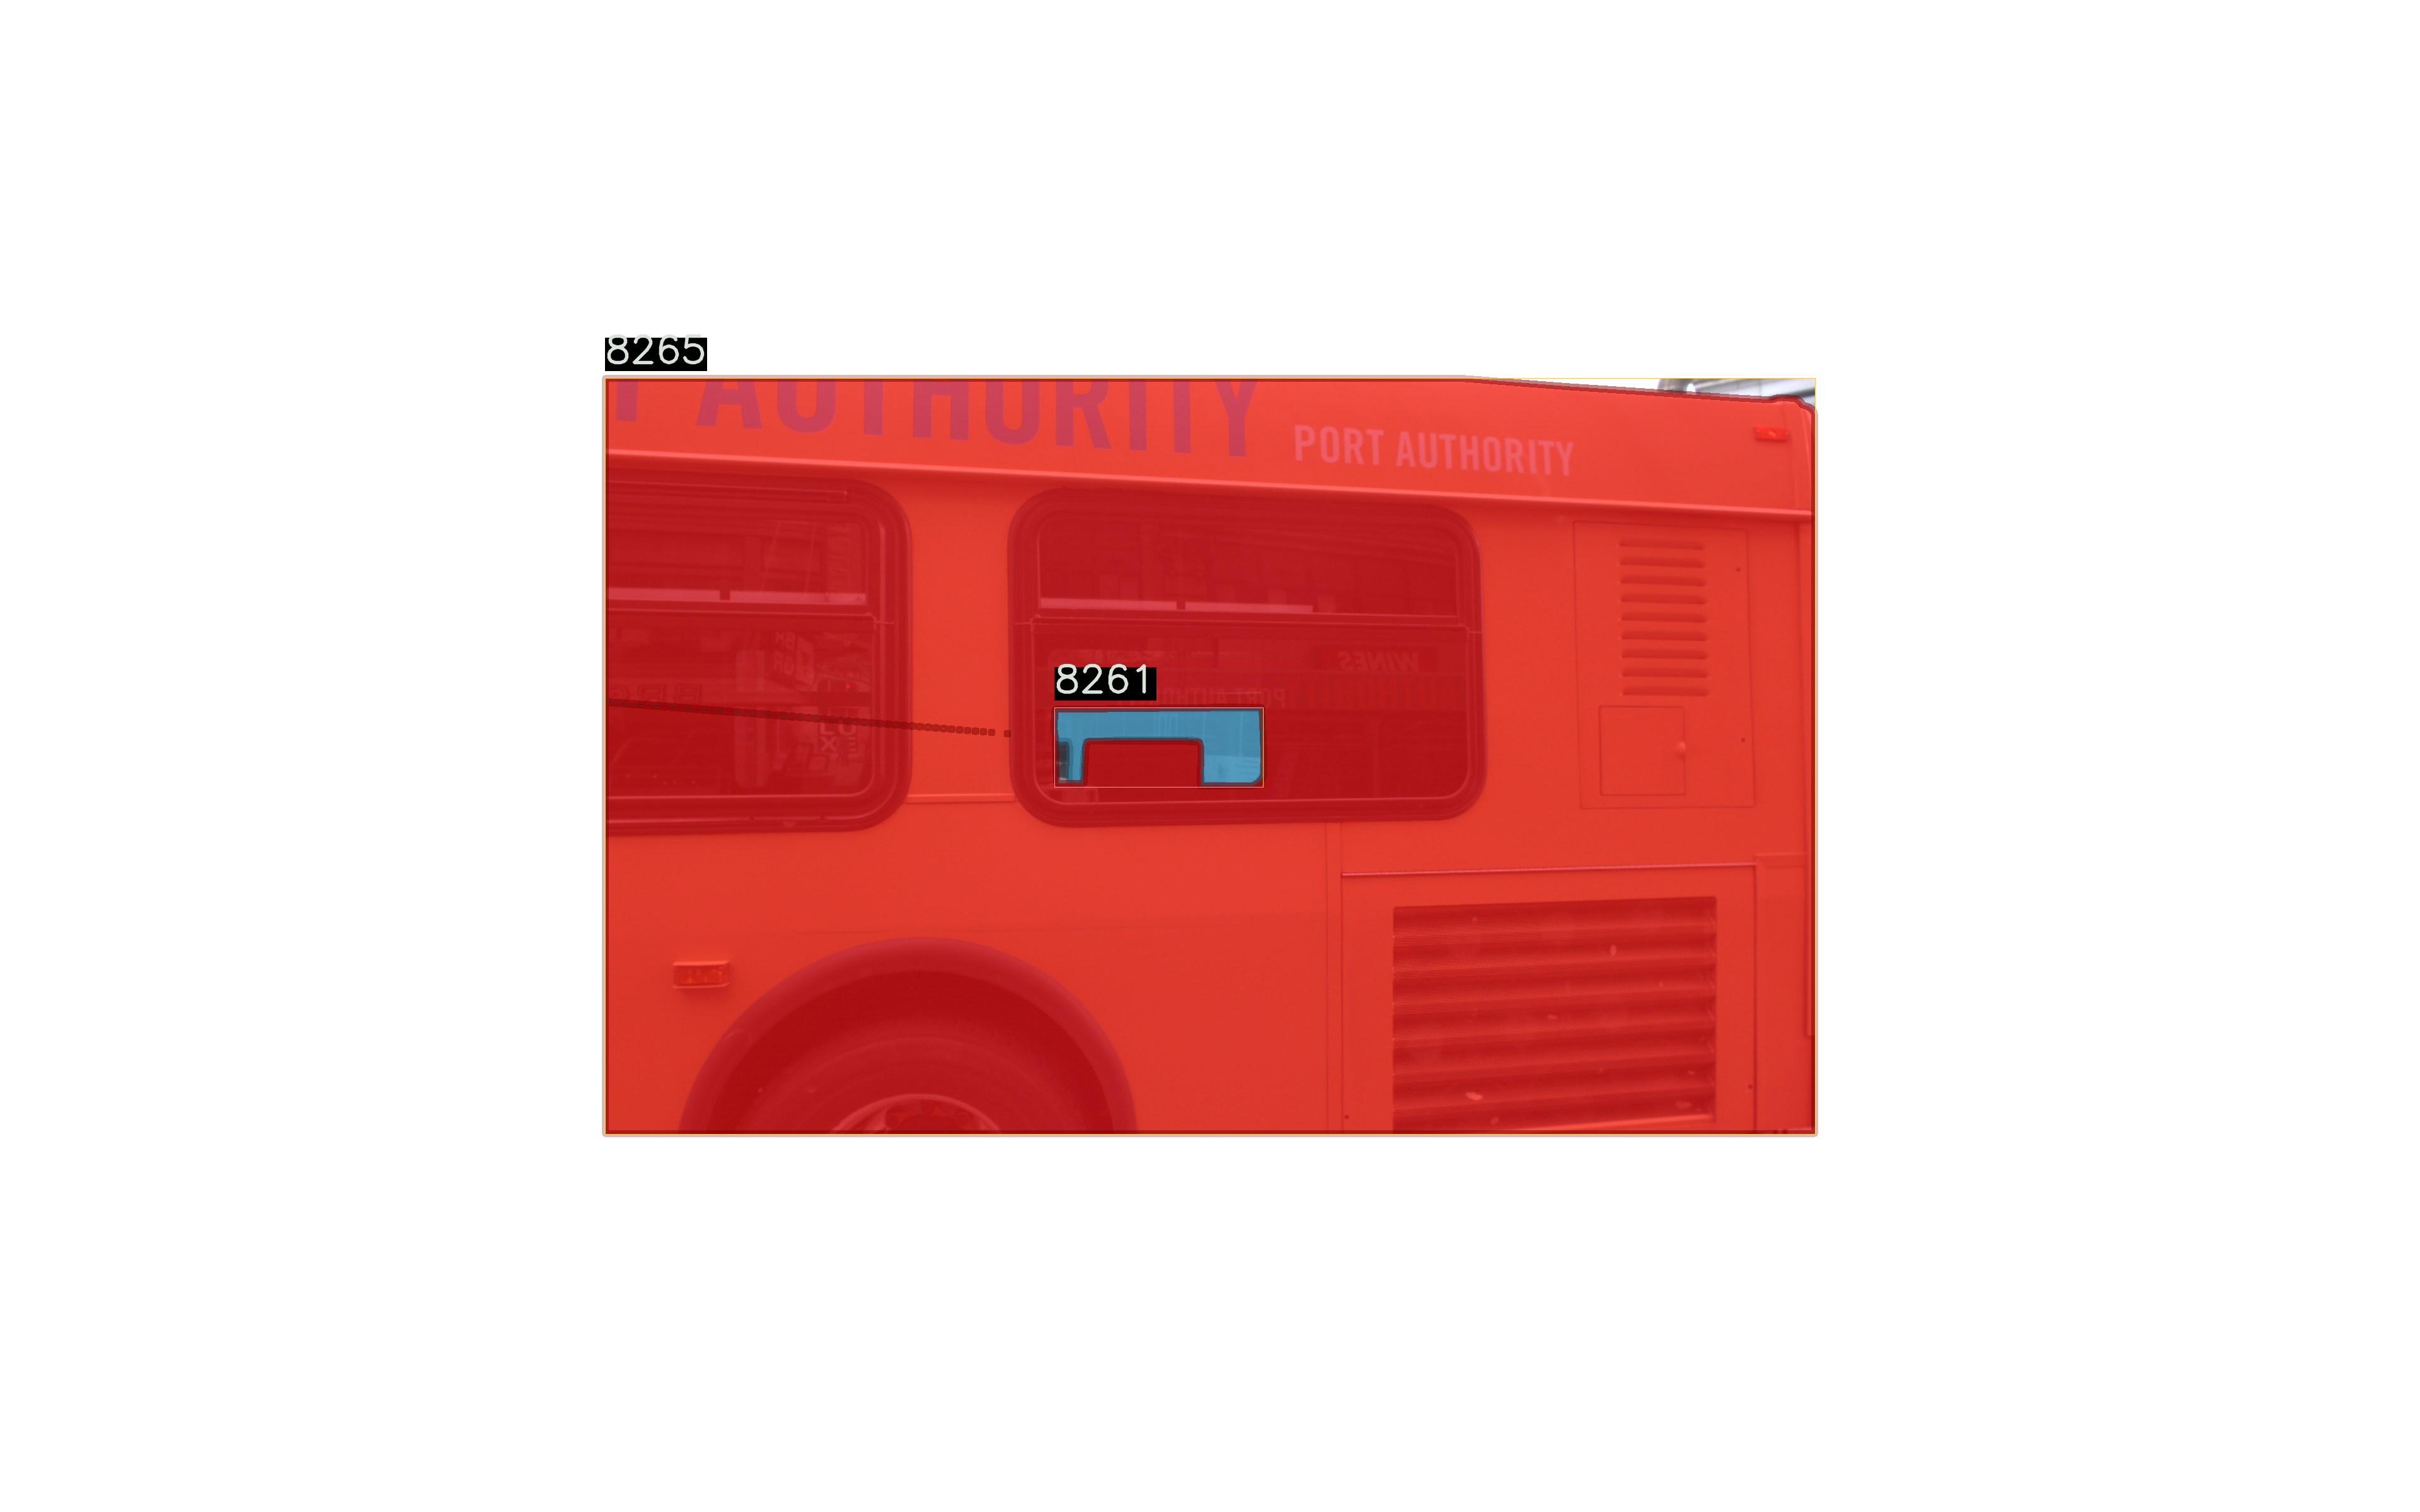

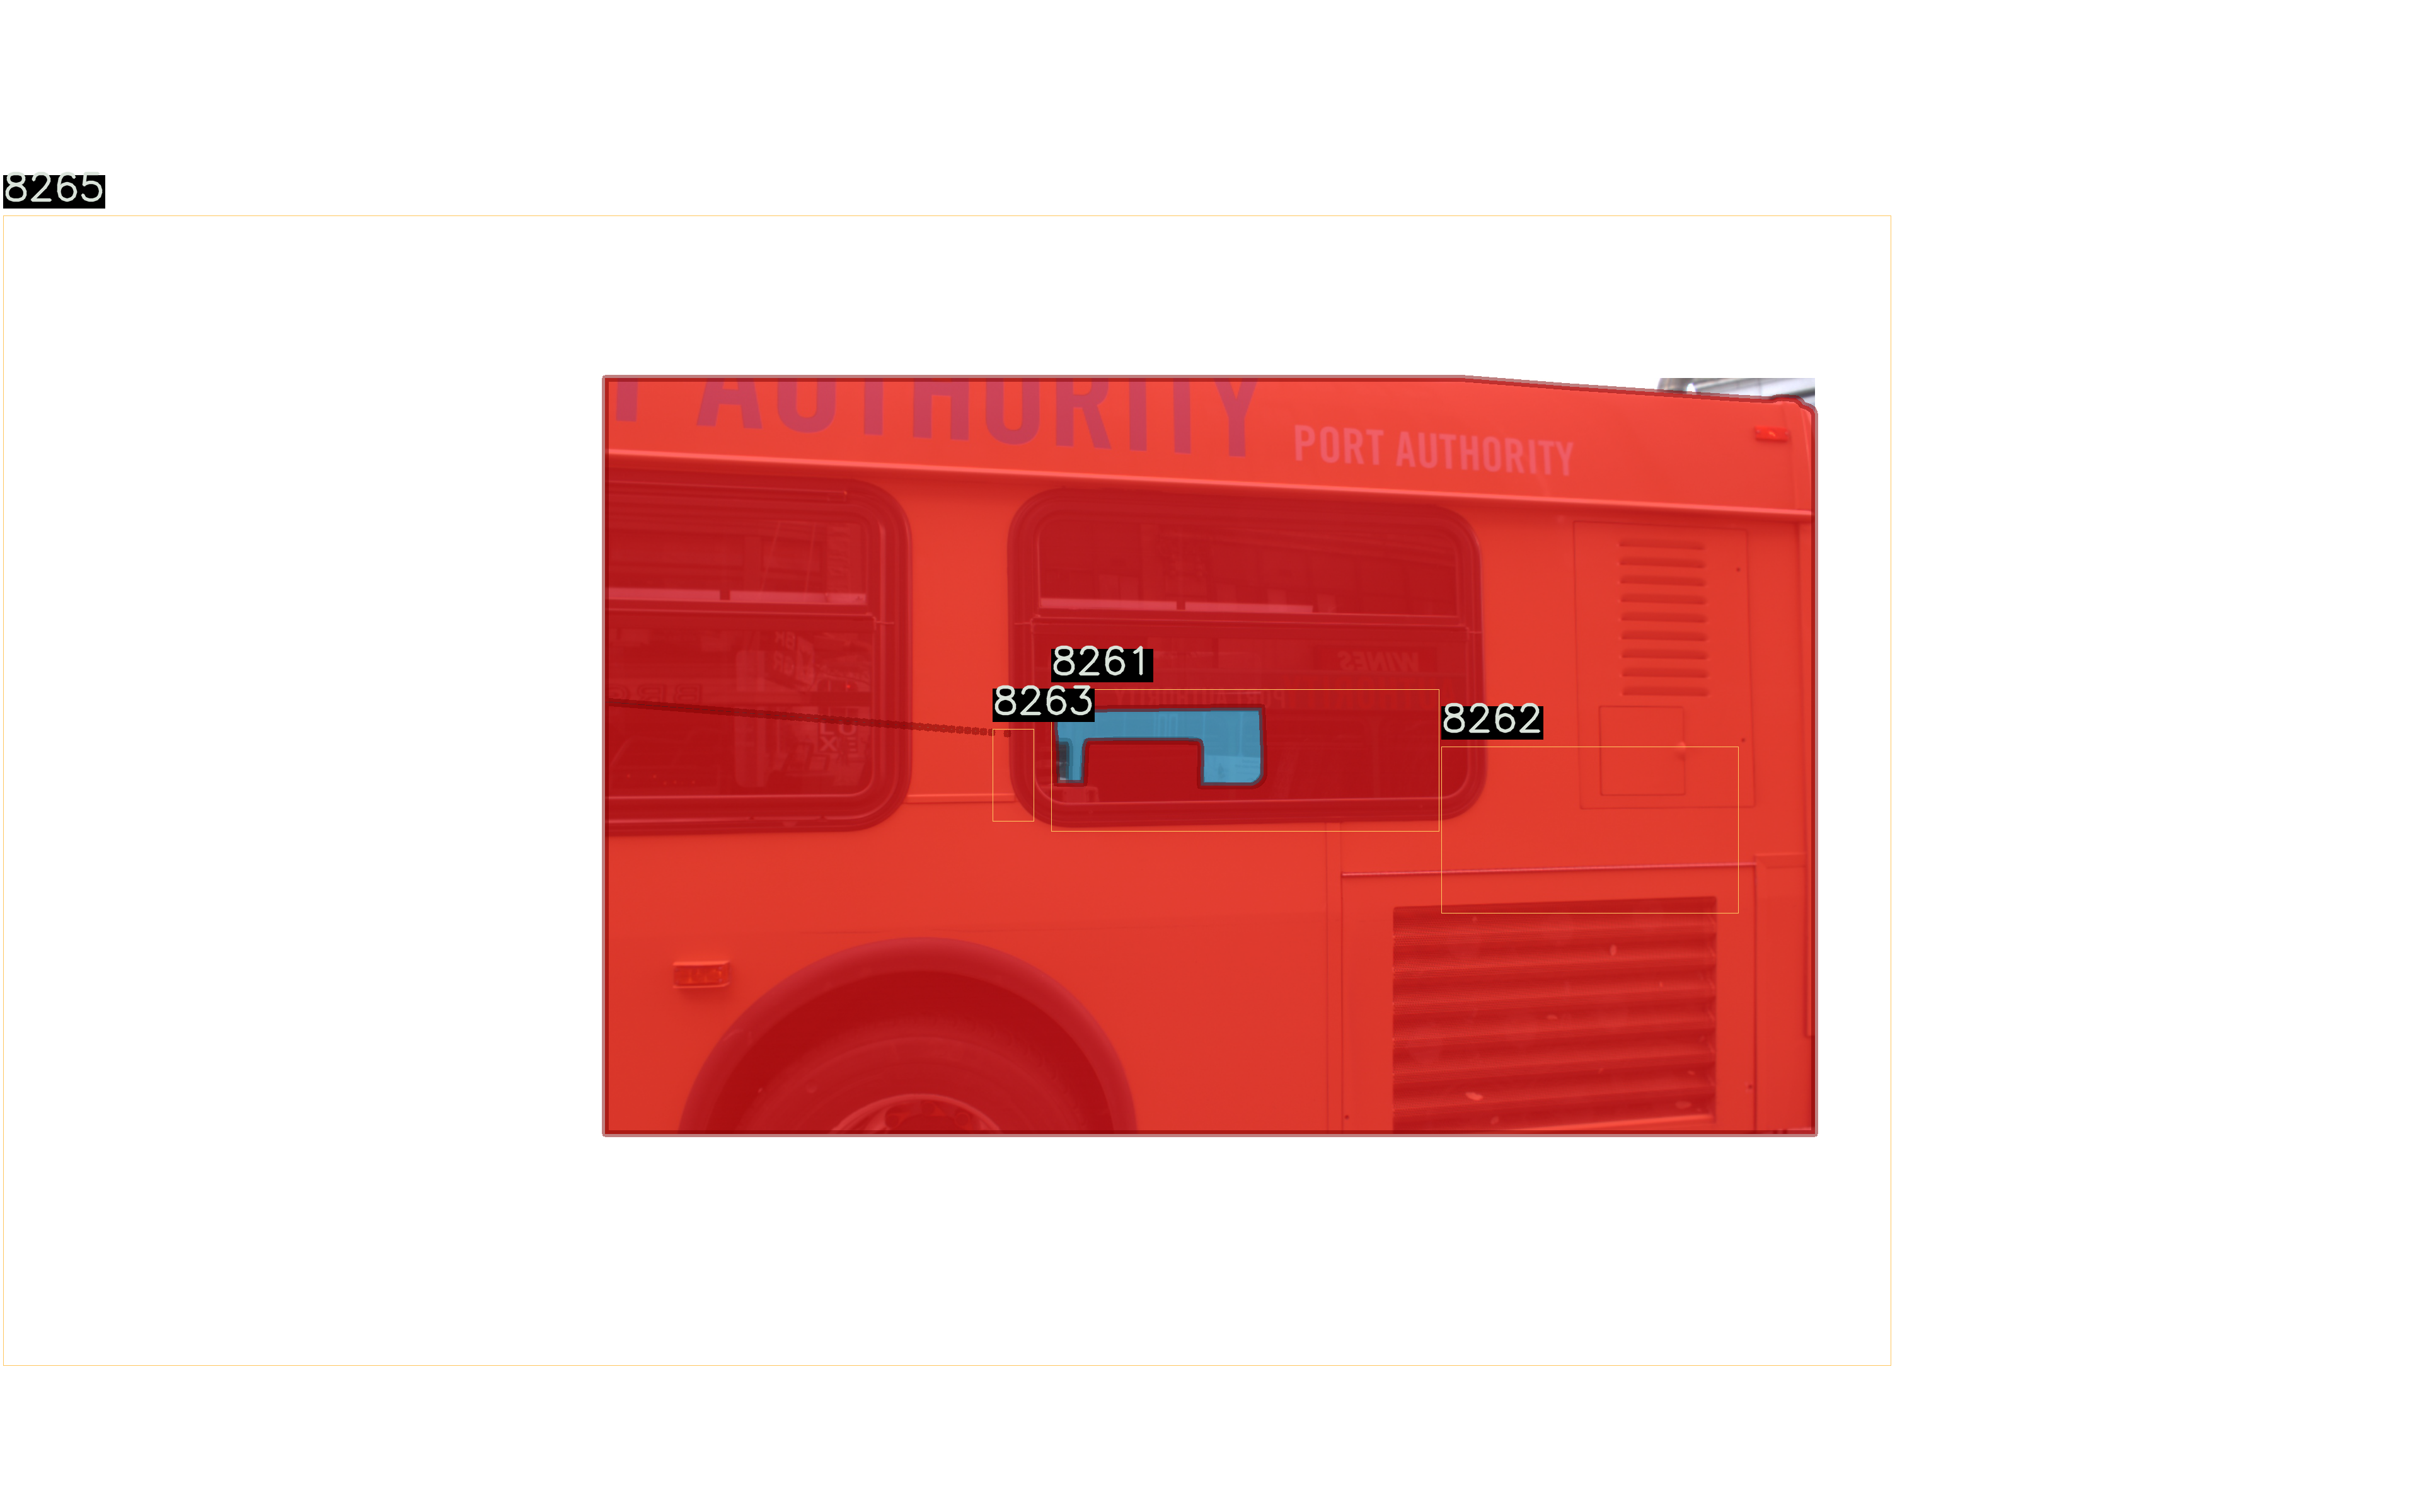

In [10]:
def transparent_except_bbox(image, all_annos, opacity=0.6, modal=True):
    with_fill = np.ones_like(image) * 255
    for ann in all_annos:
        oy, ox = image.shape[:2]
        oy, ox = int(oy / 4), int(ox / 4)

        if modal and 'bbox' not in ann:
            continue
        box = ann['bbox'] if modal else ann['amodal_bbox']
        box = [max(0, box[0]+ox), max(0, box[1]+oy), min(image.shape[1], box[2]+box[0]+ox), min(image.shape[0], box[3]+box[1]+oy)]
        with_fill[int(box[1]):int(box[3]), int(box[0]):int(box[2])] = image[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
    
    image = cv2.addWeighted(with_fill, opacity, image,
                                1 - opacity, 0, image)
    return image

def vis_image_and_annotations(image, all_annos, show_track=False, show_image_id=True, transparent=False, mask_t=None, modal=False):
    height, width = image.shape[:2]
    new_image = np.ones([height * 2, width * 2, 3], dtype=np.uint8) * 255
    startx = int(width / 2)
    endx = startx + width
    starty = int(height / 2) 
    endy = starty + height
    new_image[starty: endy, startx: endx, :] = image

    for track_id in mask_t:
        full_mask = np.zeros((1, height*2, width*2), dtype=np.uint8)
        full_mask[:, starty:endy, startx:endx] = mask_t[track_id].astype(np.uint8)
        new_image = vis_mask(new_image,
            full_mask,
            color_map[track_id] if track_id != 8876 else (255, 199, 96),
            alpha=0.6,
            show_border=True,
            border_alpha=0.5,
            border_thick=10,
            border_color=None)
        # new_image = vis_mask(new_image,
        #     full_mask,
        #     (138, 135, 140),
        #     alpha=0.4,
        #     show_border=True,
        #     border_alpha=0.5,
        #     border_thick=1,
        #     border_color=None)
            
    with open(annotation_file, 'r') as f:
        lvis = json.load(f)
        id_to_cat_name = {cat['id']: cat['name'] for cat in lvis['categories']}

    if transparent:
        new_image = transparent_except_bbox(new_image, all_annos, modal=modal, opacity=0.45)
    

    for ann in all_annos:
        # if ann['category_id'] != 793 or ann['track_id'] in [1000001, 1000004, 1000007, 1000008]:
        #     continue
        oy, ox = new_image.shape[:2]
        oy, ox = int(oy / 4), int(ox / 4)

        if modal and 'bbox' not in ann:
            continue
        box = ann['bbox'] if modal else ann['amodal_bbox']
        box = [box[0]+ox, box[1]+oy, box[2]+box[0]+ox, box[3]+box[1]+oy]
        # new_image = vis_bbox(new_image, box, fill_opacity=0.32, fill_color=None, border_color=color_map[ann['track_id']], thickness=1)
        new_image = vis_bbox(new_image, box, fill_opacity=0.32, fill_color=None, border_color=(255, 199, 96), thickness=1)
        
        if not show_track:
            if id_to_cat_name[ann['category_id']] == "baby":
                id_to_cat_name[ann['category_id']] = "person"
            # new_image = vis_class(new_image, box[:2], id_to_cat_name[ann['category_id']])
            pass
        else:
            new_image = vis_class(new_image, box[:2], str(ann['track_id']))
    

    # Check bounding box, Check Category
    if all_annos and show_image_id:
        new_image = vis_class(new_image, [int(startx + (endx - startx)* 0.4 ), starty // 2], str(all_annos[-1]['image_id']),
                                    bg_color=(255, 255, 255),
                                    text_color=(0, 0, 0),
                                    font_scale=2.5,
                                    thickness=3)
    pil_image = Image.fromarray(new_image)
    return pil_image

def vis_class(image,
              pos,
              class_str,
              font_scale=2.0,
              bg_color=_BLACK,
              text_color=_GRAY,
              thickness=4):
    """Visualizes the class."""
    x, y = int(pos[0]), int(pos[1])
    # Compute text size.
    txt = class_str
    font = cv2.FONT_HERSHEY_SIMPLEX
    ((txt_w, txt_h), _) = cv2.getTextSize(txt, font, font_scale, 1)
    # Place text background.
    back_tl = x, y - int(1.5 * txt_h)
    back_br = x + txt_w, y - int(0.3 * txt_h)
    # Show text.
    txt_tl = x, y - int(0.6 * txt_h)
    cv2.rectangle(image, back_tl, back_br, bg_color, -1)
    cv2.putText(image,
                txt,
                txt_tl,
                font,
                font_scale,
                text_color,
                thickness=thickness,
                lineType=cv2.LINE_AA)
    return image

def vis_bbox(image,
             box,
             border_color=_BLACK,
             fill_color=_COLOR1,
             fill_opacity=0.65,
             thickness=2):
    """Visualizes a bounding box."""
    x0, y0, x1, y1 = box
    x1, y1 = int(x1), int(y1)
    x0, y0 = int(x0), int(y0)
    # Draw border
    if fill_opacity > 0 and fill_color is not None:
        with_fill = image.copy()
        with_fill = cv2.rectangle(with_fill, (x0, y0), (x1, y1),
                                  tuple(fill_color), cv2.FILLED)
        image = cv2.addWeighted(with_fill, fill_opacity, image,
                                1 - fill_opacity, 0, image)
        
    image = cv2.rectangle(image, (x0, y0), (x1, y1), tuple(border_color),
                          thickness)
    return image

save_dir = "/data3/chengyeh/TAO-Amodal-Visualization/Paper-Mask-And-Box"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
display_on_notebook = True
IMAGE_ROOT='/compute/trinity-1-38/chengyeh/TAO/frames'

# Load BURST dataset
dataset = BURSTDataset(annotations_file=mask_annotation,
                           images_base_dir=IMAGE_ROOT)

# Randomly visualize 100 images
img_ids = np.random.choice(list(img_id_to_img.keys()), size=100)
img_ids = [47893]

filter_with_track = False
track_id = [8876]
show_track = True
show_image_id = False
score_thresh = 0.5
transparent = True

with open(os.path.join(save_dir, 'mask_box_GT.html'), 'w') as f:
    f.write('<!DOCTYPE html>\n')
    f.write('<html>\n')
    f.write('<body>\n')
    f.write('<style>\n')
    f.write('table, th, td {\n')
    f.write('border:1px solid black;\n')
    f.write('}\n')
    f.write('</style>\n')
    f.write('<body>\n')
    f.write('<h2>Qualitative Results</h2>\n\n')
    f.write(('<table style="width:100%">\n'
                '<tr>\n'
                '<th>Modal</th>\n'
                '<th>Amodal</th>\n'
                '</tr>\n')
                )
    for i,img_id in enumerate(img_ids):
        print("{}/{}".format(i + 1, len(img_ids)), end='\r')

        # Preprocess the mask
        burst_video = dataset.get_video_by_name(img_id_to_vname[img_id])
        mask_t = burst_video.get_mask_by_frame(img_id_to_img[img_id]['file_name'])
            
        img_path = os.path.join(IMAGE_ROOT, img_id_to_img[img_id]['file_name'])
        np_image = utils.read_image(img_path)

        # Amodal GT
        selected_anns = [pred for pred in img_id_to_ann[img_id]] 
        if filter_with_track:
            selected_anns = [pred for pred in img_id_to_ann[img_id] if pred['track_id'] in track_id]
        new_mask_t = {}
        for t_id in mask_t:
            min_track_id = min(vid_to_tracks[img_id_to_img[img_id]['video_id']])
            if filter_with_track and (t_id - 1 + min_track_id) not in track_id:
                continue
            new_mask_t[t_id - 1 + min_track_id] = mask_t[t_id]

        if not os.path.isdir(os.path.dirname(os.path.join(save_dir, img_id_to_img[img_id]['file_name'].replace('.', '_modal.')))):
            os.makedirs(os.path.dirname(os.path.join(save_dir, img_id_to_img[img_id]['file_name'].replace('.', '_modal.'))))
        pil_image = vis_image_and_annotations(np_image, selected_anns, show_track, show_image_id, transparent, new_mask_t, modal=True)
        pil_image.save(os.path.join(save_dir, img_id_to_img[img_id]['file_name'].replace('.', '_modal.')))
        if display_on_notebook:
            display(pil_image)

        # Modal GT
        pil_image = vis_image_and_annotations(np_image, selected_anns, show_track, show_image_id, transparent, new_mask_t, modal=False)
        pil_image.save(os.path.join(save_dir, img_id_to_img[img_id]['file_name'].replace('.', '_amodal.')))
        if display_on_notebook:
            display(pil_image)
        
        f.write('<tr>\n')
        f.write('<td><img src=\"{}\" alt="Modal" style="width:1200px;"></td>\n'.format(os.path.join(img_id_to_img[img_id]['file_name'].replace('.', '_modal.'))))
        f.write('<td><img src=\"{}\" alt="Amodal" style="width:1200px;"></td>\n'.format(os.path.join(img_id_to_img[img_id]['file_name'].replace('.', '_amodal.'))))
        f.write('/<tr>\n')
    
    f.write(('</table>\n\n'
            '</body>\n'
            '</html>'))